# Proyecto 2
## RSNA 2022 Cervical Spine Fracture Detection
**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Data Science**

---

## Integrantes
- Gustavo Gonzalez
- Pablo Orellana
- Diego Leiva
- Maria Ramirez

## Librerias

NOTA: Importante tener el Token de la API en el folder `C:\Users\<Windows-username>\.kaggle\kaggle.json`

Para una guia mas detallada o si tiene otro sistema dirigase a: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

Asimismo puede visitar la documentacion oficial de la API: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

Si no utilizara la API de Kaggle para descargar el conjunto de datos comente las lineas para importar la libreria de kaggle.

In [5]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones de archivos
import os
import pickle
import zipfile
import shutil

# Operaciones de datos
import pandas as pd
import numpy as np
from collections import defaultdict

# Operaciones de imágenes
from PIL import Image

# Visualización
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Utilidades
import random
import time
import uuid

# Pytorch y Torchvision
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# from torch.optim import lr_scheduler
# from torchvision import transforms

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Warnings
# import warnings
# warnings.filterwarnings('ignore')

### Configuración de variable de entorno para CUDA
De no tener un equipo compatible con CUDA, o si ya tiene configurado el PATH de CUDA, comente la siguiente línea.
Para mas detalle puede visitar las guias de CUDA Toolkit en el siguiente enlace: https://docs.nvidia.com/cuda/archive/12.4.0/

In [6]:
# Ruta para CUDA 12.4
# os.environ['CUDA_PATH'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit//CUDA//v12.4"  

## Carga de Dataset

In [7]:
# Definir competencia y directorio de conjunto de datos
competition_name = 'rsna-2022-cervical-spine-fracture-detection'
target_path = 'data'

# Bandera para habilitar o deshabilitar la descarga de datos
download_data = False

### Descargar el archivo con Kaggle

Puede omitir esta celda si decide descargar los archivos manualmente en el siguiente enlace:
https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview

Puede que necesite aceptar las reglas de la competencia en: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/rules

Aceptelas y siga los pasos que se le muestren en pantalla.

In [8]:
if download_data:
    # Autenticación con Kaggle API
    kaggle.api.authenticate()

    try:
        kaggle.api.competition_download_files(competition=competition_name,
                                            path='data',
                                            quiet=False,
                                            force=False)
        
        print(f"EXITO: Archivos descargados en '{target_path}'")

    except ApiException as e:
        print(f"ERROR al llamar KaggleApi -> competition_download \n\t{e}")
else:
    print("Descarga de datos realizada previamente...")

Descarga de datos realizada previamente...


### Descomprimir el Zip

Puede comentar esta celda si ya tiene los archivos descomprimidos

In [9]:
if download_data:
    try:
        # Descomprimir archivo .zip
        with zipfile.ZipFile(f'{target_path}/{competition_name}.zip', 'r') as zip_ref:
            zip_ref.extractall(target_path)

        # Eliminar archivo .zip
        os.remove(f'{target_path}/{competition_name}.zip')

        print(f"EXITO: Archivo .zip descomprimido en '{target_path}'")

    except Exception as e:
        print(f"ERROR al descomprimir archivo .zip \n\t{e}")
else:
    print("Descompresión de archivos realizada previamente...")
    print(f"Conjunto de datos en '{target_path}'")

Descompresión de archivos realizada previamente...
Conjunto de datos en 'data'


Deberia de tener los siguientes archivos dentro de la carpeta `data`

- segmentations
  - archivos .nii
- test_images
  - archivos .dcm
- train_images
  - 1.2.826.0....
    - archivos .dcm
  - ...  
- sample_submission.csv
- test.csv
- train_bounding_boxes.csv
- train.csv

### Limpieza del entorno de trabajo

Puede comentar esta celda si no tiene estos archivos o si no desea eliminarlos.

Dado el enfoque académico de este análisis y la naturaleza de las competencias de Kaggle, los archivos relacionados con el conjunto de test no serán utilizados. Estos archivos tienen una estructura diferente al conjunto de entrenamiento y están destinados a evaluar los modelos generados en la competencia. Como no se pretende generar un modelo competitivo en este contexto, se procederá a eliminar los siguientes archivos/carpetas:
- test_images
- sampe_submission.csv
- test.csv

Además explorando la información proporcionada por kaggle, se menciona que se tomo una parte de los datos de imágenes y fue semgentada automáticamente utilizando un modelo 3D UNET, y los radiólogos modificaron y aprobaron las segmentaciones. Las etiquetas de segmentación proporcionadas tienen valores de 1 a 7 para C1 a C7 (las siete vértebras cervicales) y de 8 a 19 para T1 a T12 (las doce vértebras torácicas, ubicadas en el centro de la parte superior y media de la espalda), y 0 para todo lo demás. Estos datos han sido proporcionados como archivos `.nii` (formato nifti) que contienen las anotaciones a nivel pixel. Sin embargo, se indica que solo se tomó una pequeña muestra del conjunto completo. Por consiguiente también se tomó la decisión de eliminar la carpeta `segmentations`.

In [10]:
# Función para eliminar archivos o carpetas
def remove_files(paths):
    """
    Elimina archivos o carpetas de la lista de rutas especificadas.
    """
    for path in paths:
        if os.path.isdir(path):
            # Si es una carpeta, usar shutil.rmtree() para eliminarla
            try:
                shutil.rmtree(path)
                print(f"Carpeta eliminada: {path}")
            except Exception as e:
                print(f"Error al eliminar la carpeta {path}: {e}")

        elif os.path.isfile(path):
            # Si es un archivo, usar os.remove() para eliminarlo
            try:
                os.remove(path)
                print(f"Archivo eliminado: {path}")
            except Exception as e:
                print(f"Error al eliminar el archivo {path}: {e}")
        else:
            print(f"{path} no encontrado, omitiendo...")

In [11]:
# Definir los caminos a los archivos y carpetas a eliminar
paths_to_remove = [
    'data/test_images', 
    'data/sample_submission.csv', 
    'data/test.csv',
    'data/segmentations'
]

# Ejecutar la función
remove_files(paths_to_remove)

data/test_images no encontrado, omitiendo...
data/sample_submission.csv no encontrado, omitiendo...
data/test.csv no encontrado, omitiendo...
data/segmentations no encontrado, omitiendo...


### Generar dataframes

In [13]:
# Cargar archivos csv en DataFrames
train_df = pd.read_csv('data/train.csv')
bbox_df = pd.read_csv('data/train_bounding_boxes.csv')

## Comprensión Inicial de Datos Tabulares

### Información General del Dataset

In [14]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas    
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        'Valores Únicos': df.nunique(),
        'Valores Duplicados': df.duplicated().sum()
    }).reset_index(drop=True)

    # Mostrar la informacion
    print(f"\nEl dataframe tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [15]:
print("Información del Dataset 'train.csv'")
get_DF_info(train_df)

Información del Dataset 'train.csv'

El dataframe tiene 2019 filas (registros) y 9 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos,Valores Duplicados
0,StudyInstanceUID,object,0.0,2019,0
1,patient_overall,int64,0.0,2,0
2,C1,int64,0.0,2,0
3,C2,int64,0.0,2,0
4,C3,int64,0.0,2,0
5,C4,int64,0.0,2,0
6,C5,int64,0.0,2,0
7,C6,int64,0.0,2,0
8,C7,int64,0.0,2,0


El conjunto de datos `train.csv` no contiene variables con nulos, indicando que el dataframe esta completo y no requerirá un manejode nulos.

In [16]:
print("Información del Dataset 'train_bounding_boxes.csv'")
get_DF_info(bbox_df)

Información del Dataset 'train_bounding_boxes.csv'

El dataframe tiene 7217 filas (registros) y 6 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos,Valores Duplicados
0,StudyInstanceUID,object,0.0,235,0
1,x,float64,0.0,2642,0
2,y,float64,0.0,2746,0
3,width,float64,0.0,3574,0
4,height,float64,0.0,3727,0
5,slice_number,int64,0.0,458,0


El archivo `train_bounding_boxes.csv` no presenta valores nulos en sus variables, indicando que el conjunto de datos esta completo y no es necesario hacer un manejo de nulos.

### Visualizar Dataframe

In [17]:
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [18]:
bbox_df.head()

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


### Identificación de Variables

#### Train dataset

- `StudyInstanceUID`: El identificador único perteneciente al estudio realizado para cada paciente.
- `patient_overall`: El resultado general del paciente, si se encontro una fractura en cualquier vértebra o no.
- `C1 a C7`: El resultado de si se encontro una fractura en la vértebra dada o no. Su nombre hace referencia a la vértebra cervical correspondiente.

#### Bounding Boxes dataset

- `StudyInstanceUID`: El identificador único perteneciente al estudio realizado para cada paciente.
- `x`: Coordenada x del origen de la caja delimitadora.
- `y`: Coordenada y del origen de la caja delimitadora.
- `width`: Ancho de la caja delimitadora.
- `height`: Alto de la caja delimitadora.
- `slice_number`: Número del corte al que pertenece la caja.

## Análisis Exploratorio de Data Tabular

(0.0, 2800.0)

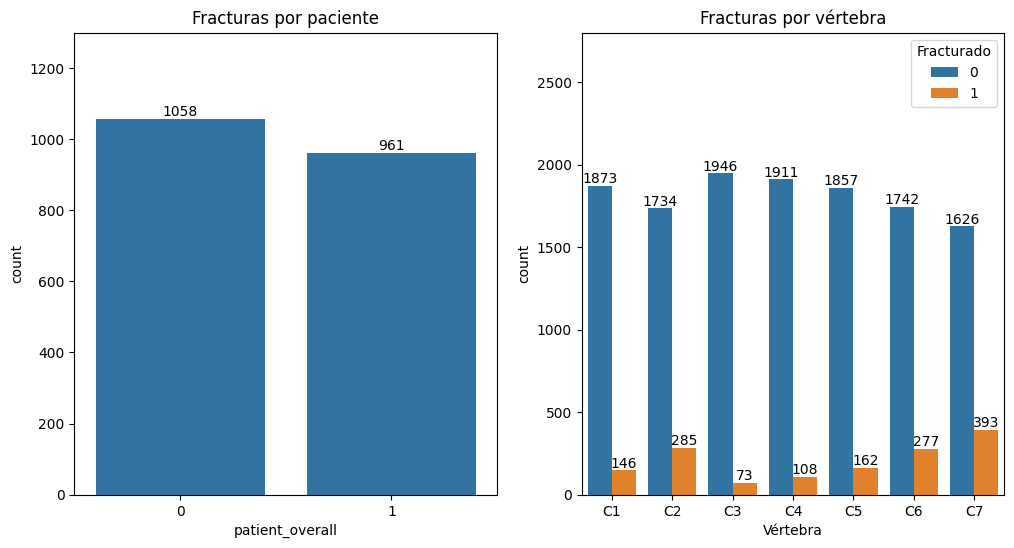

In [30]:
plt.figure(figsize=(12, 6))  

plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fracturas por paciente')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vértebra",
             value_name="Fracturado")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vértebra', hue='Fracturado')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fracturas por vértebra')
plt.ylim([0,2800])

* El dataset está balanceado 
* C7 es la vértebra que más tiende a fracturarse
* C3 es la vértebra que menos tiende a fracturarse

(0.0, 1300.0)

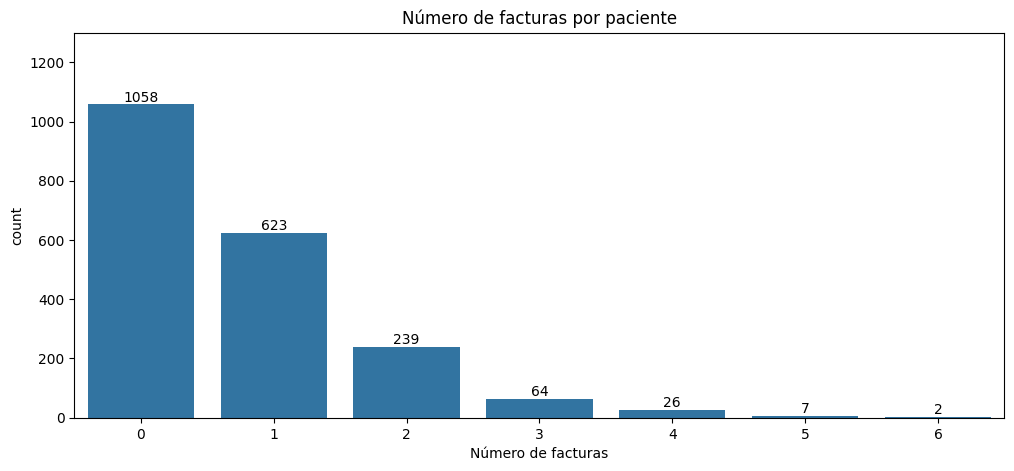

In [24]:

plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Número de facturas por paciente')
plt.xlabel('Número de facturas')
plt.ylim([0,1300])

Text(0.5, 1.0, 'Correlations')

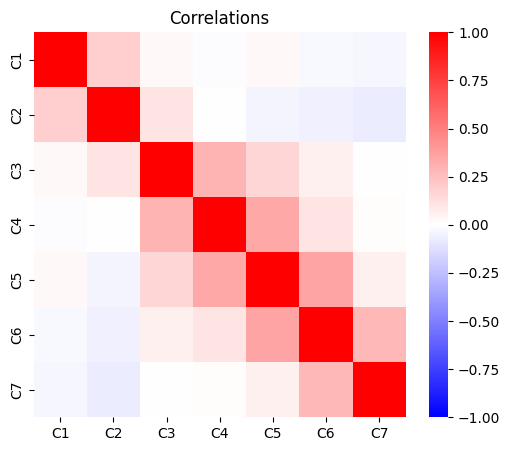

In [23]:
# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlaciones')

* Cuando ocurren varias fracturas lo normal es que se fracturen vértebras adyacentes

In [31]:
train_df['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.6200'

In [32]:
# Find unique numbers in study id's
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


* Realmente solo nos importa el último número para el ID